# Regressão Logística

Documentação:
- https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\RR}{\mathbb{R}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from ipywidgets import interact

In [2]:
def gen_data(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1], random_state=None):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    rng = np.random.RandomState(random_state)
    X = np.zeros((n_samples, 1))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        k = i % n_classes
        X[i, 0] = (k*(1-overlap) + rng.uniform())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1] - x_scale[0])*X
    return X, y

def plot_data(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap='bwr', vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap='bwr', vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap='bwr', vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

def plot_contour(X, y, w, n_levels=15, gap=20):
    w = w.reshape(-1, 2)
    a0 = np.array([w[:,0].min(), w[:,0].max()])
    a1 = np.array([w[:,1].min(), w[:,1].max()])
    width0 = a0[1] - a0[0]
    width1 = a1[1] - a1[0]
    width = 1.1*max(width0, width1)
    if width == 0:
        width = 2*gap
    if width0 < width:
        a0[0] -= (width - width0)/2
        a0[1] += (width - width0)/2
    if width1 < width:
        a1[0] -= (width - width1)/2
        a1[1] += (width - width1)/2
    w0, w1 = np.meshgrid(np.linspace(*a0, 100), np.linspace(*a1, 100))
    Z = np.log10(np.mean((w0 + X.reshape(-1, 1, 1)*w1 - y.reshape(-1, 1, 1))**2, axis=0))
    cs = plt.contour(w0, w1, Z, levels=np.linspace(Z.min(), Z.max(), n_levels), cmap='Blues_r');
    plt.colorbar();
    plt.title('log10(MSE)')
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.plot(w[:,0], w[:,1], 'r.-')
    return

## Conceitos básicos

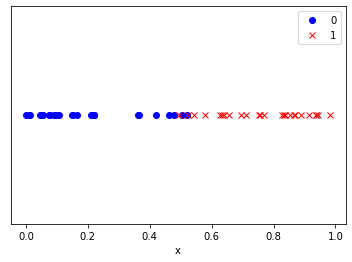

In [3]:
X, y = gen_data(n_samples=50, n_classes=2, overlap=0.1, random_state=1)
#y = np.array(['a', 'b'])[y]
plot_data(X, y)

-  Caso sua versão do sklearn seja inferior a 0.22, utilize a opção `solver='lbfgs'` (padrão a partir de 0.22) no `LogisticRegression()`

b = -31.276380601991665, w = [61.22640097]
Iterations: 16
Train accuracy: 96.0%


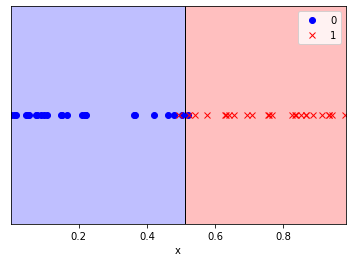

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(penalty='none')
model.fit(X, y)
print(f'b = {model.intercept_[0]}, w = {model.coef_[0]}')
print('Iterations:', model.n_iter_[0])
print(f'Train accuracy: {model.score(X, y):.1%}')
#print(f'Train accuracy: {np.mean(y == model.predict(X)):.1%}')
#print(f'Train accuracy: {accuracy_score(y, model.predict(X)):.1%}')
plot_data(X, y, model)

In [5]:
print(f'classes    : {model.classes_}')
print(f'y[:8]      : {y[:8]}')
print(f'y_pred[:8] : {model.predict(X)[:8]}')

classes    : [0 1]
y[:8]      : [0 1 0 1 0 1 0 1]
y_pred[:8] : [0 1 0 1 0 1 0 1]


- Refazer com classes `['a', 'b']` para exemplificar

Limiar das regiões de decisão:

$\hat{y} = 1 \iff z \triangleq w_1 x + b > 0 \iff x > -b/w_1$

In [6]:
gamma = -model.intercept_[0]/model.coef_[0][0]
print(f'Decision threshold on x: {gamma:.4}')

Decision threshold on x: 0.5108


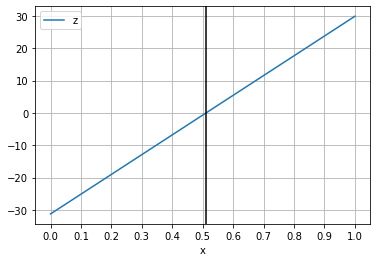

In [7]:
x = np.linspace(0, 1, 1000)

z = x.reshape(-1, 1) @ model.coef_[0] + model.intercept_[0]
z = model.decision_function(x.reshape(-1, 1))

plt.plot(x, z, label='z')
plt.axvline(gamma, color='k')
plt.xlabel('x')
plt.xticks(np.linspace(0, 1, 11))
plt.grid()
plt.legend();

Predição do modelo de regressão:

$p = \tilde{y} = \sigma(w_1x + b)$  $\quad$ (estimativa de $P[y=1|x]$)

onde $\sigma(z) = 1/(1 + e^{-z})$

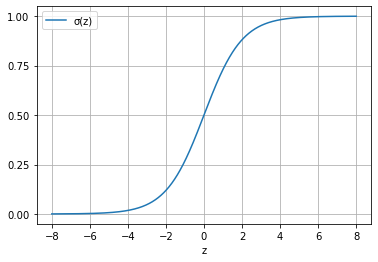

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

#def sigmoid(z): # this version avoids overflow warnings
#    return np.exp(np.minimum(z, 0))/(1 + np.exp(-np.abs(z)))

#sigmoid = lambda z: np.exp(np.minimum(z, 0))/(1 + np.exp(-np.abs(z)))

from scipy.special import expit as sigmoid

z = np.linspace(-8, 8, 1000)
plt.plot(z, sigmoid(z), label='σ(z)')
plt.xlabel('z')
plt.legend();
plt.yticks(np.linspace(0, 1, 5))
plt.grid();

#sigmoid(-1000)

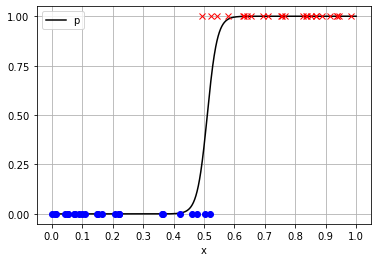

In [9]:
x = np.linspace(0, 1, 1000)

z = model.decision_function(x.reshape(-1, 1))
p = sigmoid(z)

p = model.predict_proba(x.reshape(-1, 1))[:, 1]

plt.plot(x, p, 'k-', label='p');
plt.plot(X[y == 0], y[y == 0], 'bo');
plt.plot(X[y == 1], y[y == 1], 'rx');
plt.xlabel('x');
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 5))
plt.grid();
plt.legend(loc='upper left');

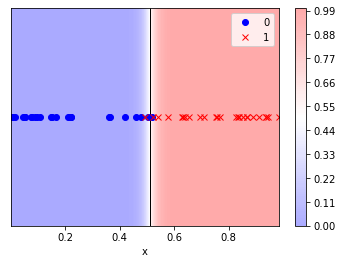

In [10]:
plot_data(X, y, model, heatmap=True)
plt.colorbar();

In [11]:
@interact(overlap=(0, 1, 0.1))
def _(overlap=0.1):
    X, y = gen_data(n_samples=50, n_classes=2, overlap=overlap, random_state=1)
    model = LogisticRegression(penalty='none')
    model.fit(X, y)
    x = np.linspace(0, 1, 1000)
    p = model.predict_proba(x.reshape(-1, 1))[:, 1]
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.title('overlap = ' + str(overlap))
    plt.plot(x, p, 'k-', label='p')
    plt.plot(X[y == 0], y[y == 0], 'bo')
    plt.plot(X[y == 1], y[y == 1], 'rx')
    plt.xlabel('x')
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 5))
    plt.grid()
    plt.legend()
    plt.subplot(1, 2, 2)    
    plot_data(X, y, model, heatmap=True)
    #plt.colorbar();

interactive(children=(FloatSlider(value=0.1, description='overlap', max=1.0), Output()), _dom_classes=('widget…

## Implementação em Python

Para realizar o treinamento utilizaremos o otimizador do SciPy com o método BFGS (padrão do SciPy para problemas sem restrições), um método quase-Newton que requer apenas o cálculo do gradiente.

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LogReg(BaseEstimator, ClassifierMixin):
    '''Logistic regression'''
    def __init__(self):
        return
    
    def _add_ones_column(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return X
    
    def fit(self, X, y):
        '''Fit using BFGS solver (SciPy's default)'''
        from scipy.optimize import minimize
        
        def fobj(w):
            p = sigmoid(X @ w)
            cost = np.mean(-y*np.log(p + 1e-200) - (1 - y)*np.log(1 - p + 1e-200))
            grad = (1/X.shape[0])*(X.T @ (p - y))
            self.cost_history.append(cost)
            self.weight_history.append(w)
            return cost, grad
        
        self.classes_ = np.unique(y)
        assert list(self.classes_) == [0, 1]
        self.cost_history = []
        self.weight_history = []
        X = self._add_ones_column(X)
        res = minimize(fun=fobj, x0=np.zeros(X.shape[1]), jac=True)
        self.res = res
        self.w = res.x
        self.intercept_ = self.w[0]
        self.coef_ = self.w[1:]
        self.n_iter_ = res.nit
        self.cost = res.fun
        return self
    
    def decision_function(self, X):
        X = self._add_ones_column(X)
        z = X @ self.w
        return z
    
    def predict_proba(self, X):
        p = sigmoid(self.decision_function(X))
        return np.c_[1 - p, p]

    def predict(self, X):
        y_pred = (self.decision_function(X) > 0).astype(int)
        return y_pred

b = -31.276380601991665, w = [61.22640097]
Iterations: 16
Cost: 0.07203407911253844
Train accuracy: 96.0%


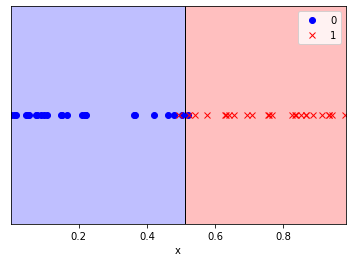

In [13]:
model = LogisticRegression(penalty='none')
model.fit(X, y)
print(f'b = {model.intercept_[0]}, w = {model.coef_[0]}')
print('Iterations:', model.n_iter_[0])
p = model.predict_proba(X)[:, 1]
cost = np.mean(-y*np.log(p + 1e-200) - (1 - y)*np.log(1 - p + 1e-200))
print('Cost:', cost)
print(f'Train accuracy: {model.score(X, y):.1%}')
plot_data(X, y, model)

b = -31.292076561212873, w = [61.25779038]
Iterations: 21
Cost: 0.07203408407098716
Train accuracy: 96.0%


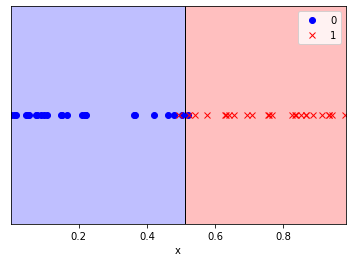

In [14]:
model = LogReg()
model.fit(X, y)
print(f'b = {model.intercept_}, w = {model.coef_}')
print('Iterations:', model.n_iter_)
p = model.predict_proba(X)[:, 1]
cost = np.mean(-y*np.log(p + 1e-200) - (1 - y)*np.log(1 - p + 1e-200))
print('Cost:', cost)
print(f'Train accuracy: {model.score(X, y):.1%}')
plot_data(X, y, model)

In [15]:
model.res

      fun: 0.07203408407098716
 hess_inv: array([[ 16520.40308951, -32070.42272235],
       [-32070.42272235,  62404.0998194 ]])
      jac: array([6.84558632e-06, 3.79759152e-06])
  message: 'Optimization terminated successfully.'
     nfev: 23
      nit: 21
     njev: 23
   status: 0
  success: True
        x: array([-31.29207656,  61.25779038])

In [16]:
len(model.cost_history)

23

In [17]:
print('Condition number:', np.linalg.cond(model.res.hess_inv))

Condition number: 2562.5985825451635


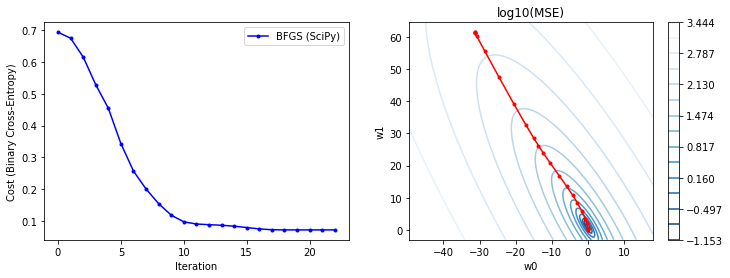

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(model.cost_history, 'b.-', label='BFGS (SciPy)')
plt.xlabel('Iteration')
plt.ylabel('Cost (Binary Cross-Entropy)')
plt.legend()
#plt.yscale('log')
plt.subplot(1,2,2)
plot_contour(X, y, np.array(model.weight_history))

## Avaliação de classificadores binários

In [19]:
X, y = None, None

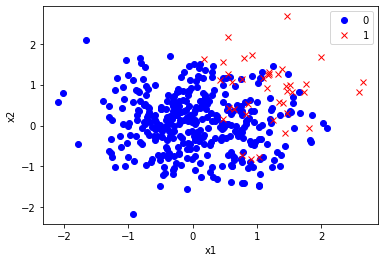

In [20]:
def gen_data2(n_samples=400, positive=0.1, cluster_std=0.75, random_state=None):
    from sklearn.datasets import make_blobs
    if type(positive) == float:
        positive = int(round(positive*n_samples))
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[0,0]], cluster_std=cluster_std, random_state=random_state)
    X[:positive] += [1, 1]
    y[:positive] += 1
    return X, y

X_train, y_train = gen_data2(random_state=4)
X_test,  y_test  = gen_data2(random_state=1)
plot_data(X_train, y_train)

### Acurácia

b = -4.51483758186681, w = [2.29215143 1.80369057]
Train accuracy: 92.2%
 Test accuracy: 93.5%


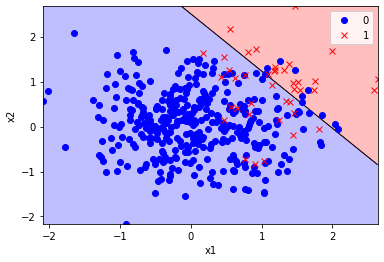

In [21]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
print(f'b = {model.intercept_[0]}, w = {model.coef_[0]}')
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')
plot_data(X_train, y_train, model)

**Pergunta:** Você identifica algum problema no uso da acurácia para avaliação de desempenho nesse conjunto específico?

In [22]:
p = [(y_train == i).mean() for i in [0,1]]
p

[0.9, 0.1]

In [23]:
print('Dummy classifier')
print(f'Train accuracy: {np.mean(y_train == 0):.1%}')
print(f' Test accuracy: {np.mean(y_test == 0):.1%}')

Dummy classifier
Train accuracy: 90.0%
 Test accuracy: 90.0%


In [24]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
print('Dummy classifier')
print(f'Train accuracy: {dummy.score(X_train, y_train):.1%}')
print(f' Test accuracy: {dummy.score(X_test, y_test):.1%}')

Dummy classifier
Train accuracy: 90.0%
 Test accuracy: 90.0%


In [25]:
def balanced_accuracy_score(y_true, y_pred):
    p = np.array([(y_true == i).mean() for i in np.unique(y_train)])
    return accuracy_score(y_true, y_pred, sample_weight=1/p[y_true])

In [26]:
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)):.1%}')

Train balanced accuracy: 72.4%
 Test balanced accuracy: 73.1%


In [27]:
print('Dummy classifier')
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, dummy.predict(X_train)):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, dummy.predict(X_test)):.1%}')

Dummy classifier
Train balanced accuracy: 50.0%
 Test balanced accuracy: 50.0%


In [28]:
from sklearn.metrics import balanced_accuracy_score

In [29]:
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)):.1%}')

Train balanced accuracy: 72.4%
 Test balanced accuracy: 73.1%


b = -4.51483758186681, w = [2.29215143 1.80369057]
Train accuracy: 92.2%
 Test accuracy: 93.5%
Train balanced accuracy: 72.4%
 Test balanced accuracy: 73.1%


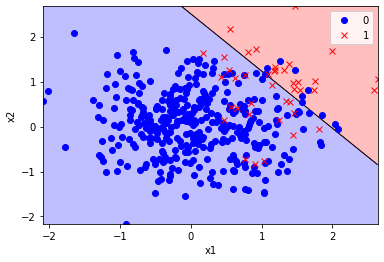

In [30]:
model = LogisticRegression(penalty='none')
#model = LogisticRegression(penalty='none', class_weight={0: 1/p[0], 1: 1/p[1]})
#model = LogisticRegression(penalty='none', class_weight={0: 1, 1: 9})
#model = LogisticRegression(penalty='none', class_weight='balanced')
model.fit(X_train, y_train)
print(f'b = {model.intercept_[0]}, w = {model.coef_[0]}')
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')
print(f'Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.1%}')
print(f' Test balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)):.1%}')
plot_data(X_train, y_train, model)

### Matriz de confusão e curva ROC

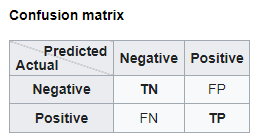

- TNR = TN/(TN + FP)
- FPR = FP/(TN + FP)
- FNR = FN/(TP + FN)
- TPR = TP/(TP + FN)
- Accuracy = (TN + TP)/(TN + FP + FN + TP) = p(0)$\cdot$TNR + p(1)$\cdot$TPR
- Balanced accuracy = (TNR + TPR)/2

In [31]:
from sklearn.metrics import confusion_matrix
M = confusion_matrix(y_test, model.predict(X_test))
print(M)

[[355   5]
 [ 21  19]]


In [32]:
tnr = M[0,0]/(M[0,0] + M[0,1])
fpr = M[0,1]/(M[0,0] + M[0,1])
fnr = M[1,0]/(M[1,0] + M[1,1])
tpr = M[1,1]/(M[1,0] + M[1,1])
acc = (M[0,0] + M[1,1])/M.sum()
bac = (tnr + tpr)/2

print(f' True negative rate: {tnr: >6.1%}')
print(f'False positive rate: {fpr: >6.1%}')
print(f'False negative rate: {fnr: >6.1%}')
print(f' True positive rate: {tpr: >6.1%}')
print(f'           Accuracy: {acc: >6.1%}')
print(f'  Balanced accuracy: {bac: >6.1%}')

 True negative rate:  98.6%
False positive rate:   1.4%
False negative rate:  52.5%
 True positive rate:  47.5%
           Accuracy:  93.5%
  Balanced accuracy:  73.1%


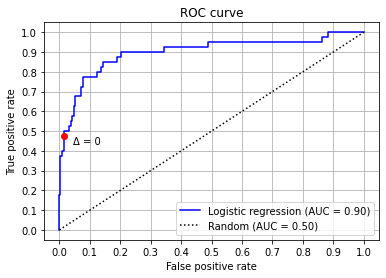

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
fprs, tprs, thresholds = roc_curve(y_test, model.decision_function(X_test))
auc = roc_auc_score(y_test, model.decision_function(X_test))
plt.plot(fprs, tprs, 'b-', label=f'Logistic regression (AUC = {auc:.2f})')
plt.plot(fpr, tpr, 'ro')
plt.annotate('Δ = 0', (fpr+0.03, tpr-0.04))
plt.plot([0, 1], [0, 1], 'k:', label='Random (AUC = 0.50)')
#plt.plot(fprs[i], tprs[i], 'gs'); plt.annotate(f'Δ = {thresholds[i]:.2f}', (fprs[i]+0.02, tprs[i]-0.07))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

A curva ROC é obtida variando o limiar de classificação $\Delta$:

$\hat{y} = 1 \iff z \triangleq \bw^T \bx + b \geq \Delta$

**Exercício:**
- Qual a maior taxa de verdadeiro positivo (TPR) tal que a taxa de verdadeiro negativo (TNR) seja de pelo menos 90%? 
- Qual o limiar de decisão (sobre $z$) correspondente?

Para responder as perguntas acima, basta determinar o índice (dos arrays `fprs`, `tprs`, `thresholds`) correspondente ao ponto de operação desejado, armazená-lo na variável `i` e rodar a célula seguinte. (Dica: utilize a função `np.nonzero` ou `np.where`)

- Em seguida, descomente a linha 8 da célula anterior (curva ROC) e rode-a novamente para observar o ponto de operação no gráfico.

<details><summary>Solução</summary>

```python
i = np.where(fprs <= 0.1)[0][-1] 
```
</details>

In [ ]:
i = ???
print(f' True positive rate: {tprs[i]: >6.1%}')
print(f'False positive rate: {fprs[i]: >6.1%}')
print('Decision threshold:', thresholds[i])

- Como colocar o classificador no ponto de operação desejado alterando apenas o $b$?

A princípio, bastaria subtrair o valor do limiar, mas há uma leve inconsistência nas notações do scikit-learn:

- $\hat{y} = 1 \iff z \triangleq \bw^T \bx + b \geq \Delta$ (curva ROC)
- $\hat{y} = 1 \iff z \triangleq \bw^T \bx + b > 0$ (função `predict`)

Solução: adicionar $\epsilon > 0$ para transformar $\geq$ em $>$:

$\bw^T \bx + b \geq \Delta \iff \bw^T \bx + b - \Delta \geq 0 \iff \bw^T \bx + b - \Delta > -\epsilon \iff \bw^T \bx + (b - \Delta + \epsilon) > 0$

In [35]:
model.intercept_[0]

-4.51483758186681

In [36]:
from copy import deepcopy
model2 = deepcopy(model)
model2.intercept_[0] += -thresholds[i] + 1e-9
model2.intercept_[0]

-2.8132338941305406

 True negative rate:  92.2%
False positive rate:   7.8%
False negative rate:  22.5%
 True positive rate:  77.5%
           Accuracy:  90.8%
  Balanced accuracy:  84.9%


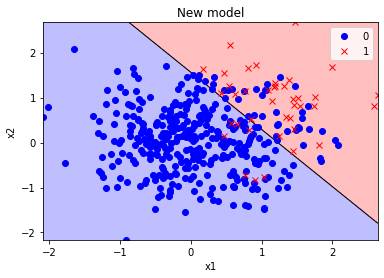

In [37]:
M = confusion_matrix(y_test, model2.predict(X_test))
print(f' True negative rate: {M[0,0]/(M[0,0] + M[0,1]): >6.1%}')
print(f'False positive rate: {M[0,1]/(M[0,0] + M[0,1]): >6.1%}')
print(f'False negative rate: {M[1,0]/(M[1,0] + M[1,1]): >6.1%}')
print(f' True positive rate: {M[1,1]/(M[1,0] + M[1,1]): >6.1%}')
print(f'           Accuracy: {accuracy_score(y_test, model2.predict(X_test)): >6.1%}')
print(f'  Balanced accuracy: {balanced_accuracy_score(y_test, model2.predict(X_test)): >6.1%}')
plot_data(X_train, y_train, model2)
plt.title('New model');

 True negative rate:  98.6%
False positive rate:   1.4%
False negative rate:  52.5%
 True positive rate:  47.5%
           Accuracy:  93.5%
  Balanced accuracy:  73.1%


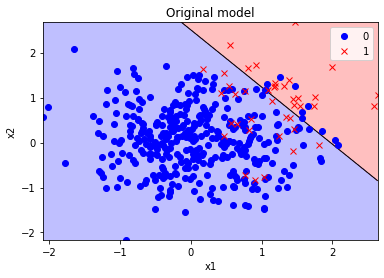

In [38]:
M = confusion_matrix(y_test, model.predict(X_test))
print(f' True negative rate: {M[0,0]/(M[0,0] + M[0,1]): >6.1%}')
print(f'False positive rate: {M[0,1]/(M[0,0] + M[0,1]): >6.1%}')
print(f'False negative rate: {M[1,0]/(M[1,0] + M[1,1]): >6.1%}')
print(f' True positive rate: {M[1,1]/(M[1,0] + M[1,1]): >6.1%}')
print(f'           Accuracy: {accuracy_score(y_test, model.predict(X_test)): >6.1%}')
print(f'  Balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)): >6.1%}')
plot_data(X_train, y_train, model)
plt.title('Original model');

## Atributos polinomiais e regularização

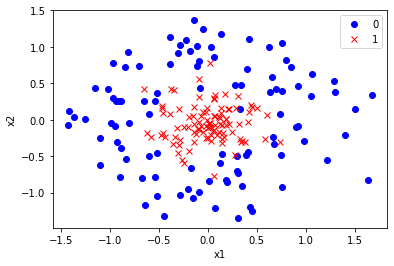

In [39]:
from sklearn.datasets import make_circles
X_train, y_train = make_circles(n_samples=200,   noise=0.28, factor=0, random_state=4)
X_val,   y_val   = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=5)
X_test,  y_test  = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=6)
plot_data(X_train, y_train)

Number of iterations: 5
Train accuracy: 58.50%
  Val accuracy: 49.00%


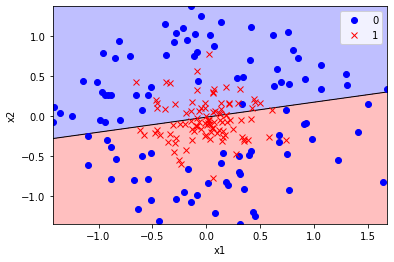

In [40]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
print('Number of iterations:', model.n_iter_[0])
print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
plot_data(X_train, y_train, model)

Vamos estender o modelo com atributos polinomiais até obter 100% de acurácia no conjunto de treinamento e em seguida regularizar para melhorar o desempenho de validação.

- Note que o sklearn utiliza como parâmetro de regularização exatamente o inverso da nossa notação: $C = 1/\lambda$.

- Caso tenha dificuldades de convergência, você pode experimentar, por exemplo:
  - aumentar o número máximo de iterações do otimizador (parâmetro `max_iter`);
  - utilizar um escalonador de atributos. Experimente aplicá-lo em diferentes posições no *pipeline* até obter os melhores resultados. (No meu caso a melhor escolha foi no início.)

In [41]:
from ipywidgets import FloatLogSlider
@interact(d=(1, 10), max_iter=FloatLogSlider(value=100, min=0, max=4, step=0.5, readout_format='d'), scale_data=False)
def _(d=1, max_iter=100, scale_data=False):
    model = make_pipeline(StandardScaler() if scale_data else None, 
                          PolynomialFeatures(d, include_bias=False), 
                          LogisticRegression(penalty='none', max_iter=max_iter))
    model.fit(X_train, y_train)
    print('Model:', [s[-1] for s in model.steps], '\n')
    print('Number of iterations:', model.steps[-1][1].n_iter_[0])
    print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
    plot_data(X_train, y_train, model)

interactive(children=(IntSlider(value=1, description='d', max=10, min=1), FloatLogSlider(value=100.0, descript…

(Obs: como visto acima, reduzir o número máximo de iterações também é uma forma de regularizar)

Aplicando regularização (L2) explicitamente:

In [42]:
d = 6
max_iter = 10000
@interact(lamb=FloatLogSlider(value=-10, min=-10, max=10, step=0.5, readout_format='.2e'))
def _(lamb):
    model = make_pipeline(StandardScaler(), PolynomialFeatures(d, include_bias=False), LogisticRegression(penalty='l2', C=1/lamb, max_iter=max_iter))
    model.fit(X_train, y_train)
    print('Model:', [s[-1] for s in model.steps], '\n')
    print('Number of iterations:', model.steps[-1][1].n_iter_[0])
    print(f'Train accuracy: {model.score(X_train, y_train):.2%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
    plot_data(X_train, y_train, model)

interactive(children=(FloatLogSlider(value=1e-10, description='lamb', max=10.0, min=-10.0, readout_format='.2e…

In [43]:
d = 2
model = make_pipeline(StandardScaler(), PolynomialFeatures(d, include_bias=False), LogisticRegression(penalty='none'))
model.fit(X_train, y_train)
print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
print(f' Test accuracy: {model.score(X_test, y_test):.2%}')

  Val accuracy: 92.80%
 Test accuracy: 93.11%


In [44]:
d = 6
lamb = 10**0.5  # = 3.16
model = make_pipeline(StandardScaler(), PolynomialFeatures(d ,include_bias=False), LogisticRegression(penalty='l2', C=1/lamb))
model.fit(X_train, y_train)
print(f'  Val accuracy: {model.score(X_val, y_val):.2%}')
print(f' Test accuracy: {model.score(X_test, y_test):.2%}')

  Val accuracy: 92.86%
 Test accuracy: 92.75%


## Classificação multiclasse

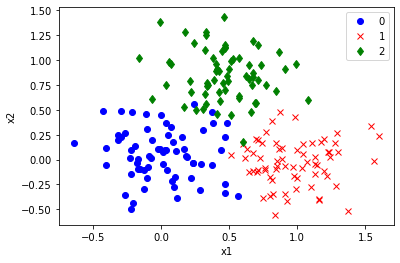

In [45]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=3, centers=[[0,0],[1,0],[0.5,np.sqrt(3/4)]], cluster_std=0.25, random_state=0)
plot_data(X, y)

### Regressão softmax

Train accuracy: 96.0%
[[63  1  3]
 [ 1 66  0]
 [ 1  2 63]]


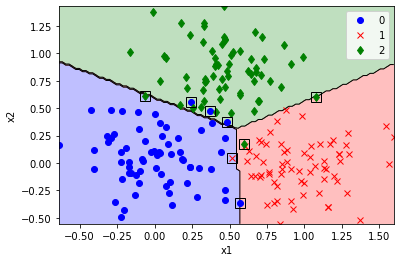

In [46]:
model = LogisticRegression(penalty='none')
#model = LogisticRegression(penalty='none', multi_class='multinomial')
model.fit(X, y)
plot_data(X, y, model, errors=True)
print(f'Train accuracy: {model.score(X, y):.1%}')
print(confusion_matrix(y, model.predict(X)))

### Regressão logística one-vs-rest (OVR)

Train accuracy: 96.5%
[[63  1  3]
 [ 1 66  0]
 [ 1  1 64]]


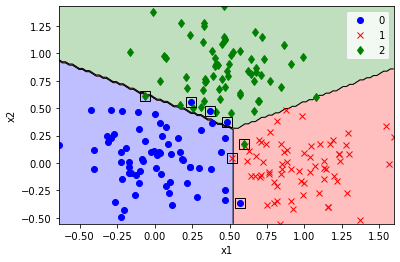

In [47]:
model = LogisticRegression(penalty='none', multi_class='ovr')
model.fit(X, y)
plot_data(X, y, model, errors=True)
print(f'Train accuracy: {model.score(X, y):.1%}')
print(confusion_matrix(y, model.predict(X)))

Train accuracy: 96.5%
[[63  1  3]
 [ 1 66  0]
 [ 1  1 64]]


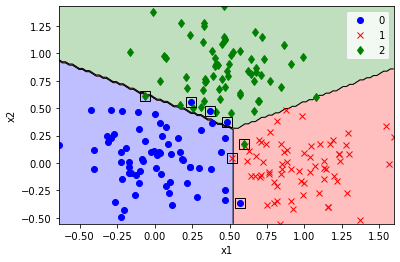

In [48]:
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression(penalty='none'))
model.fit(X, y)
plot_data(X, y, model, errors=True)
print(f'Train accuracy: {model.score(X, y):.1%}')
print(confusion_matrix(y, model.predict(X)))

In [49]:
model.estimators_

[LogisticRegression(penalty='none'),
 LogisticRegression(penalty='none'),
 LogisticRegression(penalty='none')]

[6.01828441] [[-12.63099064  -7.56641963]]
[-8.54062769] [[14.99454629 -7.52746363]]
[-9.47065833] [[ 1.46220278 18.47954767]]


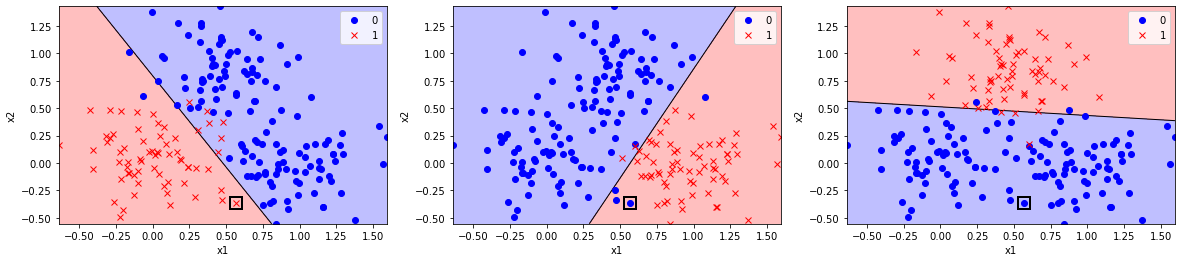

In [50]:
plt.figure(figsize=(20, 4))
for i, estimator in enumerate(model.estimators_):
    print(estimator.intercept_, estimator.coef_)
    plt.subplot(1, 3, i+1)
    plot_data(X, y==i, estimator)
    plt.plot(*X[0], 'ks', mfc='none', markersize=12, markeredgewidth=2)

In [51]:
for estimator in model.estimators_:
    print(estimator.decision_function(X[[0]]))

[1.6020573]
[2.70477868]
[-15.35995291]


In [52]:
model.decision_function(X[[0]])

array([[  1.6020573 ,   2.70477868, -15.35995291]])

In [53]:
for estimator in model.estimators_:
    print(estimator.predict_proba(X[[0]])[:, 1])

[0.83230573]
[0.93730803]
[2.13430812e-07]


In [54]:
model.predict_proba(X[[0]])

array([[4.70331800e-01, 5.29668080e-01, 1.20608684e-07]])

### Implementação em Python

In [55]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import label_binarize

class OneVsRest(BaseEstimator, ClassifierMixin):
    '''One-Vs-Rest Classification'''
    def __init__(self, estimator):
        self.estimator = estimator
        return
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        Y = label_binarize(y, classes=self.classes_)
        self.estimators_ = [clone(self.estimator).fit(X, Y[:, k]) for k in range(self.n_classes_)]
        return self
    
    def decision_function(self, X):
        return np.column_stack([self.estimators_[k].decision_function(X) for k in range(self.n_classes_)])
    
    def predict_proba(self, X):
        P = np.column_stack([self.estimators_[k].predict_proba(X)[:, 1] for k in range(self.n_classes_)])
        return P / P.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        Z = self.decision_function(X)
        return self.classes_[Z.argmax(axis=1)]

In [56]:
model = OneVsRest(LogisticRegression(penalty='none'))
model.fit(X, y)
print(f'decision_function:\n{model.decision_function(X[:2])}\n')
print(f'predict_proba:\n{model.predict_proba(X[:2])}\n')
print(f'predict:\n{model.predict(X[:2])}\n')
print(f'score: {model.score(X, y)}')

decision_function:
[[  1.6020573    2.70477868 -15.35995291]
 [ -6.03151657  -4.8566845    3.2486235 ]]

predict_proba:
[[4.70331800e-01 5.29668080e-01 1.20608684e-07]
 [2.46325186e-03 7.93249225e-03 9.89604256e-01]]

predict:
[1 2]

score: 0.965


In [57]:
model = OneVsRestClassifier(LogisticRegression(penalty='none'))
model.fit(X, y)
print(f'decision_function:\n{model.decision_function(X[:2])}\n')
print(f'predict_proba:\n{model.predict_proba(X[:2])}\n')
print(f'predict:\n{model.predict(X[:2])}\n')
print(f'score: {model.score(X, y)}')

decision_function:
[[  1.6020573    2.70477868 -15.35995291]
 [ -6.03151657  -4.8566845    3.2486235 ]]

predict_proba:
[[4.70331800e-01 5.29668080e-01 1.20608684e-07]
 [2.46325186e-03 7.93249225e-03 9.89604256e-01]]

predict:
[1 2]

score: 0.965


### Comparação entre softmax e one-vs-rest

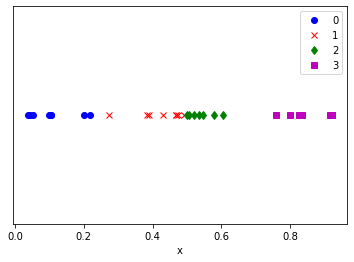

In [58]:
X, y = gen_data(n_samples=30, n_classes=4, overlap=0, random_state=1)
plot_data(X, y)

#### One-versus-rest

Iterations: 23
Train accuracy: 83.3%


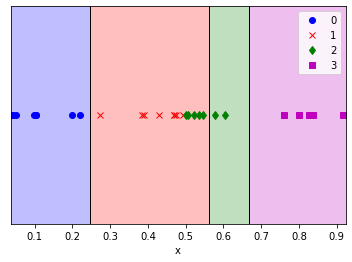

In [59]:
model = LogisticRegression(penalty='none', multi_class='ovr')
model.fit(X, y)
plot_data(X, y, model)
print('Iterations:', model.n_iter_[0])
print('Train accuracy: {:.1%}'.format(model.score(X, y)))

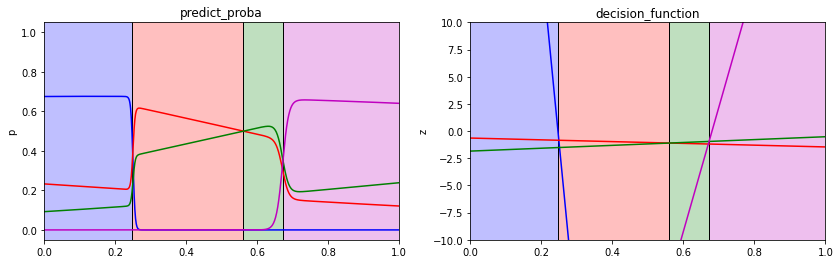

In [60]:
def plot_regions_1d(model, x_range, y_range, colors=['b','r','g','m','c','y'], N=100, gap=1e-9):
    xx1, xx2 = np.meshgrid(np.linspace(*x_range, N), np.linspace(*y_range, 2))
    y_pred = model.predict(xx1.reshape(-1, 1)).reshape(xx1.shape)
    levels = np.arange(len(model.classes_) + 1) - 0.5
    plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
    plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
    return

colors = ['b','r','g','m','c','y']
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
p = model.predict_proba(x.reshape(-1, 1))
for k in range(len(model.classes_)):
    plt.plot(x, p[:, k], colors[k])
plt.title('predict_proba')
plt.ylabel('p')
plt.xlim([x.min(), x.max()])
plt.ylim([-0.05, 1.05])
plot_regions_1d(model, plt.xlim(), plt.ylim())
plt.subplot(1, 2, 2)
z = model.decision_function(x.reshape(-1, 1))
for k in range(len(model.classes_)):
    plt.plot(x, z[:, k], colors[k])
plt.title('decision_function')
plt.ylabel('z')
plt.xlim([x.min(), x.max()])
plt.ylim([-10, 10])
plot_regions_1d(model, plt.xlim(), plt.ylim())
plt.show()

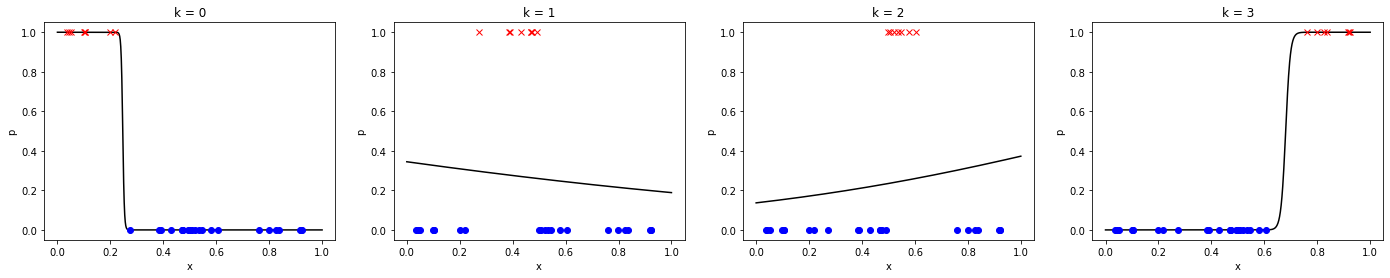

In [61]:
# Probabilities for the positive class for each individual OVR classifier
x = np.linspace(0, 1, 1000)
p = sigmoid(model.decision_function(x.reshape(-1, 1)))
plt.figure(figsize=(24,4))
for k in range(len(model.classes_)):
    plt.subplot(1, 4, k+1)
    plt.title(f'k = {k}')
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x, p[:, k], 'k-');
    plt.plot(X[y != k], np.zeros(np.sum([y != k])), 'bo');
    plt.plot(X[y == k], np.ones(np.sum([y == k])), 'rx');

#### Softmax

Iterations: 31
Train accuracy: 100.0%


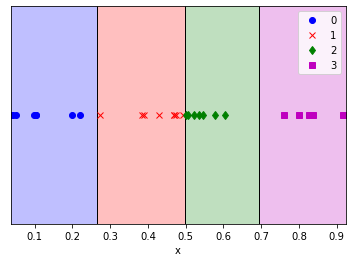

In [62]:
model = LogisticRegression(penalty='none')
#model = LogisticRegression(penalty='none', max_iter=12)
model.fit(X, y)
plot_data(X, y, model)
print('Iterations:', model.n_iter_[0])
print('Train accuracy: {:.1%}'.format(model.score(X, y)))

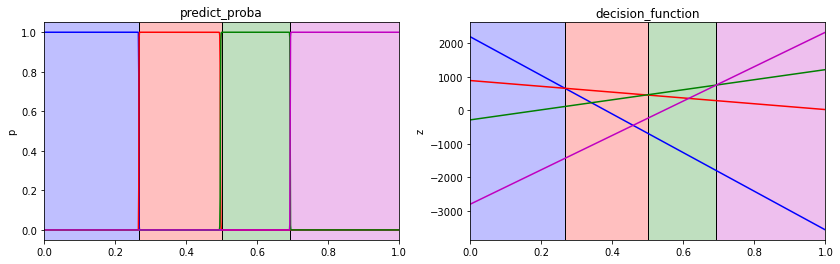

In [63]:
colors = ['b','r','g','m','c','y']
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
p = model.predict_proba(x.reshape(-1, 1))
for k in range(len(model.classes_)):
    plt.plot(x, p[:, k], colors[k])
plt.title('predict_proba')
plt.ylabel('p')
plt.xlim([x.min(), x.max()])
plt.ylim([-0.05, 1.05])
plot_regions_1d(model, plt.xlim(), plt.ylim())
plt.subplot(1, 2, 2)
z = model.decision_function(x.reshape(-1, 1))
for k in range(len(model.classes_)):
    plt.plot(x, z[:, k], colors[k])
plt.title('decision_function')
plt.ylabel('z')
plt.xlim([x.min(), x.max()])
#plt.ylim([-10, 10])
plot_regions_1d(model, plt.xlim(), plt.ylim())
plt.show()

**Softmax**

$p_k = \displaystyle\frac{e^{z_k}}{\sum_{i=1}^K e^{z_i}}$

$L(\by, \bp) = -\sum_{k=1}^K y_k \log(p_k)$

- Experimentar com `max_iter=12` para verificar a redução de confiança

**Vantagens do classificador one-vs-rest:**
- Pode ser aplicado a qualquer classificador binário
- Os classificadores individuais podem ser treinados em paralelo

**Vantagens do classificador softmax:**
- Treinamento conjunto pode resultar em um melhor desempenho em alguns casos
- Mais simples de descrever matematicamente